In [618]:
import numpy as np
import torch, scipy

torch.set_default_dtype(torch.float32)
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [619]:
S = 2**16
RN = 32
Channel = 1
TS = 300

In [620]:
import os, pickle, Samp

lat_var = Samp.generate_latent_var(S, 1, 2)
sam = Samp.generate_para_sample(RN, lat_var)
lat_var = Samp.generate_latent_var(TS, 3, 4)
Tsam = Samp.generate_para_sample(RN, lat_var)

if not os.path.exists(os.path.join(os.path.abspath('.'), 'KnownData')):
    os.mkdir(os.path.join(os.path.abspath('.'), 'KnownData'))
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'wb') as file:
    pickle.dump((sam, Tsam), file)
    
with open(os.path.join(os.path.abspath('.'), 'KnownData', 'ParaSam' + '.pickle'), 'rb') as file:
    sam, Tsam = pickle.load(file)
sam = torch.from_numpy(sam).float()
Tsam = torch.from_numpy(Tsam).float() 

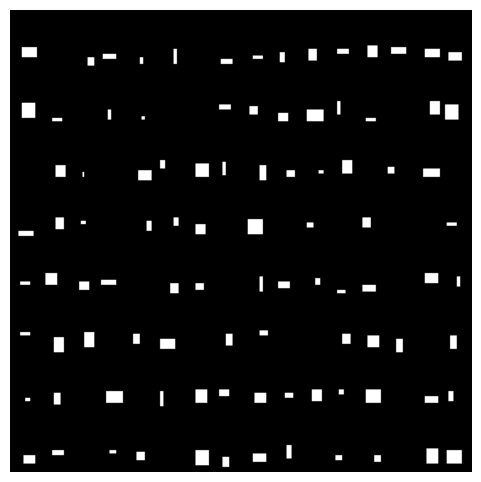

In [621]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Tsam = Tsam.clamp(0.0, 1.0)
%matplotlib inline
Tsam_grid = make_grid(Tsam[:64,...], nrow=(8))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(Tsam_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.savefig('refsam.eps', format='eps')
plt.show()

In [622]:
import torch.nn as nn

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet32(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, sde, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args: 
            sde: A 'VPSDE' object that provides the standard deviation 
                of the perturbation kernel p_{0t}(x(t) | x(0)).
            channels: The number of channels for feature maps of each resolution.
            embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, output_padding=1)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        
        # The swish activation function
        self.act = nn.SiLU()
        self.sde = sde
  
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        tt = torch.tensor(self.sde.marginal_prob_std(t)[:, None, None, None], device=device)
        # Normalize output
        h = h / tt
        return h

In [623]:
import abc

class SDE(abc.ABC):
    """SDE abstract class. Functions are designed for a mini-batch of inputs."""

    def __init__(self, N):
        """Construct an SDE.

        Args:
            N: number of discretization time steps.
        """
        super().__init__()
        self.N = N

    @property
    @abc.abstractmethod
    def T(self):
        """End time of the SDE."""
        pass

    @abc.abstractmethod
    def sde(self, x, t):
        pass

    @abc.abstractmethod
    def marginal_prob(self, x, t):
        """Parameters to determine the marginal distribution of the SDE, $p_t(x)$."""
        pass

    @abc.abstractmethod
    def prior_sampling(self, shape):
        """Generate one sample from the prior distribution, $p_T(x)$."""
        pass

    @abc.abstractmethod
    def prior_logp(self, z):
        """Compute log-density of the prior distribution.

        Useful for computing the log-likelihood via probability flow ODE.

        Args:
            z: latent code
        Returns:
            log probability density
        """
        pass

    def discretize(self, x, t):
        """Discretize the SDE in the form: x_{i+1} = x_i + f_i(x_i) + G_i z_i.

        Useful for reverse diffusion sampling and probabiliy flow sampling.
        Defaults to Euler-Maruyama discretization.

        Args:
            x: a torch tensor
            t: a torch float representing the time step (from 0 to 'self.T')

        Returns:
            f: a torch tensor representing the drift term
            G: a torch tensor representing the diffusion term
        """
        dt = 1 / self.N
        drift, diffusion = self.sde(x, t)
        f = drift * dt
        G = diffusion * torch.sqrt(torch.tensor(dt, device=t.device))
        return f, G

    def reverse(self, score_fn, probability_flow=False):
        """Create the reverse-time SDE/ODE.

        Args:
            score_fn: A time-dependent score-based model that takes x and t and returns the score.
            probability_flow: If 'True', create the reverse-time ODE used for probability flow sampling.
        """
        N = self.N
        T = self.T
        sde_fn = self.sde
        discretize_fn = self.discretize

        # Build the class for reverse-time SDE.
        class RSDE(self.__class__):
            def __init__(self):
                self.N = N
                self.probability_flow = probability_flow

            @property
            def T(self):
                return T

            def sde(self, x, t):
                """Create the drift and diffusion functions for the reverse SDE/ODE."""
                drift, diffusion = sde_fn(x, t)
                score = score_fn(x, t)
                drift = drift - diffusion[:, None, None, None] ** 2 * score * (0.5 if self.probability_flow else 1.)
                # Set the diffusion function to zero for ODEs.
                diffusion = 0. if self.probability_flow else diffusion
                return drift, diffusion

            def discretize(self, x, t):
                """Create discretized iteration rules for the reverse diffusion sampler."""
                f, G = discretize_fn(x, t)
                rev_f = f - G[:, None, None, None] ** 2 * score_fn(x, t) * (0.5 if self.probability_flow else 1.)
                rev_G = torch.zeros_like(G) if self.probability_flow else G
                return rev_f, rev_G

        return RSDE()

In [624]:
class VPSDE(SDE):
    def __init__(self, beta_min=0.1, beta_max=32, N=1000):
        """Construct a Variance Preserving SDE.

        Args:
            beta_min: value of beta(0)
            beta_max: value of beta(1)
            N: number of discretization steps
        """
        super().__init__(N)
        self.beta_0 = beta_min
        self.beta_1 = beta_max
        self.N = N
        self.discrete_betas = torch.linspace(beta_min / N, beta_max / N, N)
        self.alphas = 1. - self.discrete_betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_1m_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.continuous = True

    @property
    def T(self):
        return 1

    def sde(self, x, t):
        beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
        drift = -0.5 * beta_t[:, None, None, None] * x
        diffusion = torch.sqrt(beta_t)
        return drift, diffusion

    def marginal_prob(self, x, t):
        log_mean_coeff = torch.tensor(-0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0, device=x.device)
        mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return torch.tensor(mean, device=x.device), torch.tensor(std, device=x.device)

    def prior_sampling(self, shape):
        return torch.randn(*shape)

    def prior_logp(self, z):
        shape = z.shape
        N = np.prod(shape[1:])
        logps = -N / 2. * np.log(2 * np.pi) - torch.sum(z ** 2, dim=(1, 2, 3)) / 2.
        return logps

    def discretize(self, x, t):
        """DDPM discretization."""
        timestep = (t * (self.N - 1) / self.T).long()
        beta = self.discrete_betas.to(x.device)[timestep]
        alpha = self.alphas.to(x.device)[timestep]
        sqrt_beta = torch.sqrt(beta)
        f = torch.sqrt(alpha)[:, None, None, None] * x - x
        G = sqrt_beta
        return f, G
    
    def marginal_prob_std(self, t):
        if self.continuous:
            std = self.marginal_prob(torch.zeros((t.shape[0], Channel, RN, RN)), t)[1]
        else: 
            labels = t * (self.N - 1)
            std = self.sqrt_1m_alphas_cumprod.to(labels.device)[labels.long()]
        return std

    

In [625]:
config = {  
            'n_epochs': 32, # number of training epochs
            'batch_size': 32, # size of a mini-batch
            'learning_rate': 1e-3, # learning rate
            'sample_step': 2000, # number of step for sampling
            'sample_batch_size': 64, # size of a batch for sampling 
            'ema_decay': 0.999, # decay rate for Exponential Moving Average 
            'lr_decay': 0.9,
            'lr_threshold': 1e-5,
            'lr_min': 5e-5
            }

In [626]:
class EMA():
    def __init__(self, parameters, mu, moving_mu=True):
        """
        Args:
            parameters: Iterable of 'torch.nn.Parameter'; usually the result of
                'model.parameters()'.
            mu: The exponential decay.
            moving_mu: Whether to a moving increase mu in the beginning of training
        """
        if mu < 0.0 or mu > 1.0:
            raise ValueError('Mu must be between 0 and 1')
        self.mu = mu
        self.num_updates = 0 if moving_mu else None
        self.shadow_params = [p.clone().detach()
                            for p in parameters if p.requires_grad]
        self.collected_params = []
        self.shadow = {}
        
    def update(self, parameters):
        """
        Update currently maintained parameters.

        Call this every time the parameters are updated, such as the result of
        the 'optimizer.step()' call.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; usually the same set of
                parameters used to initialize this object.
        """
        decay = self.mu
        if self.num_updates is not None:
            self.num_updates += 1
            decay = min(decay, (1 + self.num_updates) / (100 + self.num_updates))
        one_minus_decay = 1.0 - decay
        with torch.no_grad():
            parameters = [p for p in parameters if p.requires_grad]
            for s_param, param in zip(self.shadow_params, parameters):
                s_param.sub_(one_minus_decay * (s_param - param))
                
    def copy_to(self, parameters):
        """
        Copy current parameters into given collection of parameters.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                updated with the stored moving averages.
        """
        parameters = [p for p in parameters if p.requires_grad]
        for s_param, param in zip(self.shadow_params, parameters):
            if param.requires_grad:
                param.data.copy_(s_param.data)            
                
    def store(self, parameters):
        """
        Save the current parameters for restoring later.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the 'store' method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        'copy_to' method. After validation (or model saving), use this to
        restore the former parameters.

        Args:
            parameters: Iterable of 'torch.nn.Parameter'; the parameters to be
                updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)
        
    def state_dict(self):
        return dict(decay=self.decay, num_updates=self.num_updates,
                    shadow_params=self.shadow_params)

    def load_state_dict(self, state_dict):
        self.decay = state_dict['decay']
        self.num_updates = state_dict['num_updates']
        self.shadow_params = state_dict['shadow_params']


In [627]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm.notebook import trange

class Score():
    def __init__(self, config) -> None:
        self.sde = VPSDE(N=config['sample_step'])
        self.score = ScoreNet32(sde=self.sde).to(device)
        self.n_epochs = config['n_epochs']
        self.batch_size = config['batch_size']
        self.lr = config['learning_rate']
        self.ema = EMA(self.score.parameters(), mu=config['ema_decay'])
        self.config = config
        self.likelihood_weighting = False
        
    def loss_fn(self, x, eps=1e-5):
        """The loss function for training score-based generative models.

        Args:
            model: A PyTorch model instance that represents a 
            time-dependent score-based model.
            x: A mini-batch of training data.    
            marginal_prob_std: A function that gives the standard deviation of 
            the perturbation kernel.
            eps: A tolerance value for numerical stability.
        """
        random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
        z = torch.randn_like(x, device=device)
        mean, std = self.sde.marginal_prob(x, random_t)
        perturbed_x = mean + z * std[:, None, None, None]
        perturbed_x = torch.tensor(perturbed_x, device=device)
        score = self.score(perturbed_x, random_t)
        
        if not self.likelihood_weighting:
            losses = torch.square(score * std[:, None, None, None] + z)
            losses = torch.mean(losses.reshape(losses.shape[0], -1), dim=-1)
        else:
            g2 = self.sde.sde(torch.zeros_like(x), random_t)[1] ** 2
            losses = torch.square(score + z / std[:, None, None, None])
            losses = torch.mean(losses.reshape(losses.shape[0], -1), dim=-1) * g2

        loss = torch.mean(losses)
        return loss

    def training(self, dataset, likelihood_weighting=False):
        """The training function of the score network.

        Args:
            dataset: A dataset in TensorDataset format with both features and labels.
        """
        self.likelihood_weighting = likelihood_weighting
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

        optimizer = Adam(self.score.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=self.config['lr_decay'], patience=200, 
                                      threshold=self.config['lr_threshold'], threshold_mode='rel', 
                                      cooldown=300, min_lr=self.config['lr_min'])
        tqdm_epoch = trange(self.n_epochs)
        
        self.score.train()
        for epoch in tqdm_epoch:
            avg_loss = 0.
            num_items = 0
            for x, _ in data_loader:
                x = torch.tensor(x, device=device) # x.to(device)    
                loss = self.loss_fn(x)
                optimizer.zero_grad()
                loss.backward()    
                optimizer.step()
                scheduler.step(loss)
                self.ema.update(self.score.parameters())
                #self.ema.copy_to(self.score.parameters())
                avg_loss += loss.item() * x.shape[0]
                num_items += x.shape[0]
            # Print the averaged training loss so far.
            tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items * 1000))
            # Update the checkpoint after each epoch of training.
            self.ema.restore(self.score.parameters())
            self.ema.copy_to(self.score.parameters())
            torch.save(self.score.state_dict(), 'ckpt_vp.pth')
        self.score.eval()

In [628]:
from torch.utils.data import TensorDataset

Score_Model = Score(config=config)
dataset = TensorDataset(sam, torch.empty(sam.shape[0]))
#Score_Model.training(dataset)

In [629]:
num_steps =  2000#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           sde,
                           rsde,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        sde: A 'VPSDE' object
        rsde: A 'RSDE' object
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps. 
            Equivalent to the number of discretized time steps.
        device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.
    
    Returns:
        Samples.    
    """
    init_x = sde.prior_sampling((batch_size, Channel, RN, RN)).to(device)
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in time_steps:      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            f, g = rsde.discretize(x, batch_time_step)
            mean_x = x - f * step_size
            x = mean_x + np.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x

In [630]:
signal_to_noise_ratio = 0.36 #@param {'type':'number'}

## The number of sampling steps.
num_steps = 2000#@param {'type':'integer'}
def pc_sampler(score_model, 
               sde,
               rsde,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
            score_model: A PyTorch model that represents the time-dependent score-based model.
            sde: A 'VPSDE' object
            rsde: A 'RSDE' object
            batch_size: The number of samplers to generate by calling this function once.
            num_steps: The number of sampling steps. 
                Equivalent to the number of discretized time steps.    
            device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
            eps: The smallest time step for numerical stability.
    
    Returns: 
            Samples.
    """
    init_x = sde.prior_sampling((batch_size, Channel, RN, RN)).to(device)
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in time_steps:      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x) 

            # Predictor step (Euler-Maruyama)
            f, g = rsde.discretize(x, batch_time_step)
            x_mean = x - f * step_size
            x = x_mean + np.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)    
        
        # The last step does not include any noise
        return x_mean

In [631]:
from tqdm.notebook import trange

class GDM():
    def __init__(self, config, Score_Model, sampler) -> None:
        """
        Args:
            sampler: ['Euler_Maruyama_sampler', 'pc_sampler']
        """
        self.sample_step = config['sample_step']
        self.s_n_batch = config['sample_batch_size']
        self.Score_Model = Score_Model
        self.sampler = sampler
    
    def sampling(self, num_batch=1, *args):
        """Generate a sample based on the score-based model

        Args:
            score_model: A score model. To sample the prior, use Score_NN.score.
            num_batch (int, optional): Number of batch to sample, output a sample size of 64*num_batch. Defaults to 1.

        Returns:
            Tensor: A sample with the size of (64*num_batch, Channel, resolution). Defaults to (64, 1, 32, 32)
        """
        if args:
            score_model = args[0]  
        else:
            score_model = self.Score_Model.score
        rsde = self.Score_Model.sde.reverse(score_model)
        samples = None
        tqdm_iter = trange(num_batch)
        for iter in tqdm_iter: 
            sample = self.sampler(score_model,
                                sde=self.Score_Model.sde,
                                rsde=rsde,
                                batch_size=self.s_n_batch,
                                num_steps = self.sample_step,
                                device=device)
            if samples is not None:
                samples = torch.cat((samples, sample), 0)
            else:
                samples = sample
        return samples
        

  0%|          | 0/150 [00:00<?, ?it/s]

/tmp/ipykernel_262/3791257821.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_mean_coeff = torch.tensor(-0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0, device=x.device)
/tmp/ipykernel_262/3791257821.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mean, device=x.device), torch.tensor(std, device=x.device)
/tmp/ipykernel_262/2657263077.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tt = torch.tensor(self.sde.marginal_prob_std(t)[:, None, None, None], device=device)


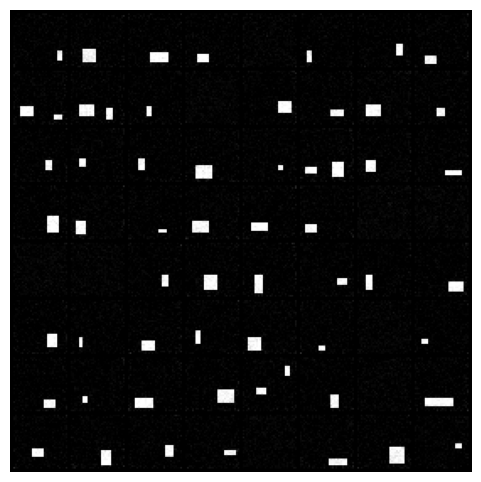

In [632]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_vp.pth', map_location=device)
Score_Model.score.load_state_dict(ckpt)
gdm = GDM(config, Score_Model, pc_sampler)
samples = gdm.sampling(num_batch=150)

from torchvision.utils import make_grid

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples[:gdm.s_n_batch,...].clamp(0.0, 1.0), nrow=int(np.sqrt(gdm.s_n_batch)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#plt.savefig('compsam_vp.eps', format='eps')
plt.show()

In [633]:
class FID():
    def __init__(self, ref_data, comp_data) -> None:
        self.eps = 1e-6
        self.orig_shape = ref_data.shape[1:]
        self.ref_data = ref_data.reshape((ref_data.shape[0], -1))
        self.comp_data = comp_data.reshape((comp_data.shape[0], -1))
        self.ref_mu = torch.mean(self.ref_data, dim=0).detach().cpu().numpy()
        self.comp_mu = torch.mean(self.comp_data, dim=0).detach().cpu().numpy()
        self.ref_sigma = torch.cov(self.ref_data.T).detach().cpu().numpy()
        self.comp_sigma = torch.cov(self.comp_data.T).detach().cpu().numpy()
        
    def calculate_frechet_distance(self):
        assert self.ref_mu.shape == self.comp_mu.shape, \
            'Training and test mean vectors have different lengths'
        assert self.ref_sigma.shape == self.comp_sigma.shape, \
            'Training and test covariances have different dimensions'
        
        diff = self.ref_mu - self.comp_mu

        # Product might be almost singular
        covmean, _ = scipy.linalg.sqrtm(self.ref_sigma.dot(self.comp_sigma), disp=False)
        if not np.isfinite(covmean).all():
            msg = ('fid calculation produces singular product; '
                'adding %s to diagonal of cov estimates') % self.eps
            print(msg)
            offset = np.eye(self.ref_sigma[0]) * self.eps
            covmean = scipy.linalg.sqrtm((self.ref_sigma + offset).dot(self.comp_sigma + offset))
        
        # Numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError('Imaginary component {}'.format(m))
            covmean = covmean.real

        tr_covmean = np.trace(covmean)

        self.FD = (diff.dot(diff) + np.trace(self.ref_sigma)
                + np.trace(self.comp_sigma) - 2 * tr_covmean)
        return self.FD
        
    def get_mean_cov(self):
        ref_mean = torch.tensor(self.ref_mu).reshape(self.orig_shape)[None, ...]
        comp_mean = torch.tensor(self.comp_mu).reshape(self.orig_shape)[None, ...]
        ref_cov = torch.tensor(self.ref_sigma)[None, None, ...]
        comp_cov = torch.tensor(self.comp_sigma)[None, None, ...]
        return ref_mean, comp_mean, ref_cov, comp_cov
        

In [634]:
fid = FID(sam, samples)
ref_mean, comp_mean, ref_cov, comp_cov = fid.get_mean_cov()
print(fid.calculate_frechet_distance())

6.707855224609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4283)


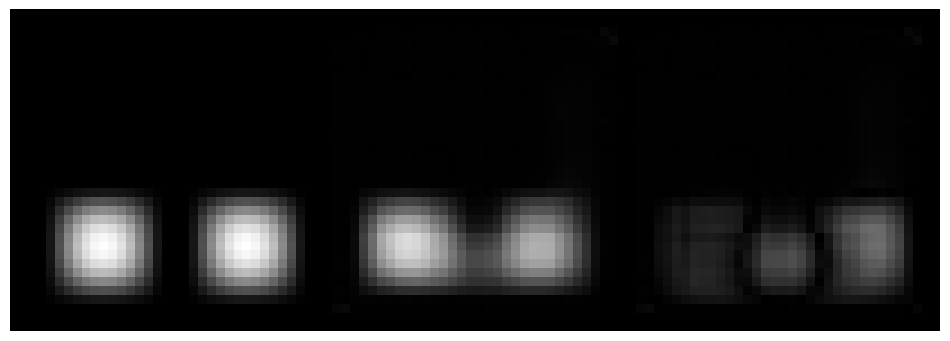

In [635]:
dsam = torch.sqrt((ref_mean - comp_mean)**2)
samp = torch.cat((ref_mean, comp_mean, dsam), dim=0)
scaler = torch.max(samp)
samp /= scaler
print(torch.max(dsam)/scaler)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samp, nrow=3)

plt.figure(figsize=(12,36))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#plt.savefig('mean_vp.eps', format='eps')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4426)


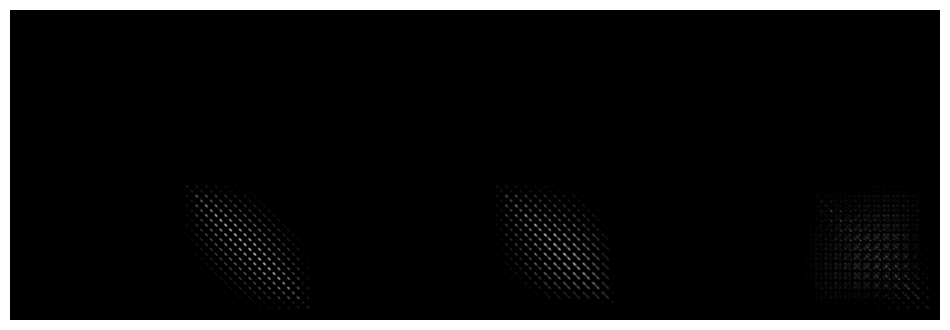

In [636]:
dsam_v = torch.sqrt((ref_cov - comp_cov)**2)
samp_v = torch.cat((ref_cov, comp_cov, dsam_v), dim=0)
scaler = torch.max(samp_v)
samp_v /= scaler
print(torch.max(dsam_v)/scaler)

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samp_v, nrow=3)

plt.figure(figsize=(12,36))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
#plt.savefig('cov_vp.eps', format='eps')
plt.show()

In [637]:
snrFID = {'0.10': 46.1,
          '0.20': 9.21,
          '0.25': 7.45,
          '0.27': 7.14,
          '0.28': 7.01,
          '0.29': 6.87,
          '0.30': 6.84,
          '0.31': 6.83,
          '0.32': 6.83,
          '0.33': 6.77,
          '0.34': 6.82,
          '0.35': 6.73,
          '0.36': 6.71,
          '0.37': 6.72,
          '0.38': 6.73,
          '0.39': 6.74,
          '0.40': 6.71,
          '0.41': 6.78,
          '0.42': 6.87,
          '0.43': 6.92,
          '0.44': 7.03,
          '0.45': 7.05,
          '0.46': 7.07,
          '0.47': 7.08,
          '0.48': 7.13,
          '0.49': 7.12,
          '0.50': 7.19,
          '0.51': 7.28,
          '0.52': 7.45,
          '0.53': 7.52,
          '0.54': 7.41,
          '0.55': 7.53,
          '0.56': 7.72,
          '0.57': 7.49,
          '0.58': 7.48,
          '0.59': 7.60,
          '0.60': 7.59,
          '0.62': 7.61,
          '0.65': 7.83,
          '0.70': 8.66, 
          '0.80': 9.97,
          '0.90': 10.56,
          '1.00': 12.51
          }

snrFID1 = {'0.05': 300.,
          '0.10': 46.90,
          '0.20': 9.76,
          '0.25': 8.01,
          '0.27': 7.90,
          '0.28': 7.86,
          '0.29': 7.78,
          '0.30': 7.87,
          '0.31': 7.90,
          '0.32': 7.82,
          '0.33': 7.53,
          '0.34': 7.57,
          '0.35': 7.70,
          '0.36': 7.69,
          '0.37': 7.90,
          '0.38': 8.18,
          '0.39': 8.26,
          '0.40': 8.42,
          '0.42': 8.30,
          '0.44': 8.13,
          '0.45': 8.05,
          '0.46': 8.15,
          '0.47': 8.21,
          '0.48': 8.17,
          '0.49': 8.10,
          '0.50': 8.06,
          '0.51': 7.92,
          '0.52': 7.70,
          '0.53': 8.64,
          '0.54': 8.95,
          '0.55': 9.38,
          '0.60': 8.79,
          '0.70': 14.29, 
          '0.80': 9.80,
          '0.90': 12.39,
          '1.00': 10.87,
          '1.05': 11.39,
          '1.10': 22.86
          }